# Lab9 - Spatial Data Analysis
Exploratory spatial data analysis of CitiBike data using pysal and geopandas

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [11]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Import initial libraries

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pylab as plt

## Working with Shape File

### Loading Census Tract Shape File¶

In [2]:
from geopandas import GeoDataFrame
shape_path="Data/CT_Shape/ct_shape.shp"
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index=ct_shape.BoroCT2010

### Coordinate systems, projections, and transformations 

In [3]:
from fiona.crs import from_epsg
ct_shape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
NYC_Area=ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 
print 'total NYC land area: %s (mi^2)'%str(NYC_Area)[:5] # from ft2 to mi2 #epsg=2263 is US feet

total NYC land area: 302.3 (mi^2)


### Visualize the Cencus Tract boundaries colored by boroughs

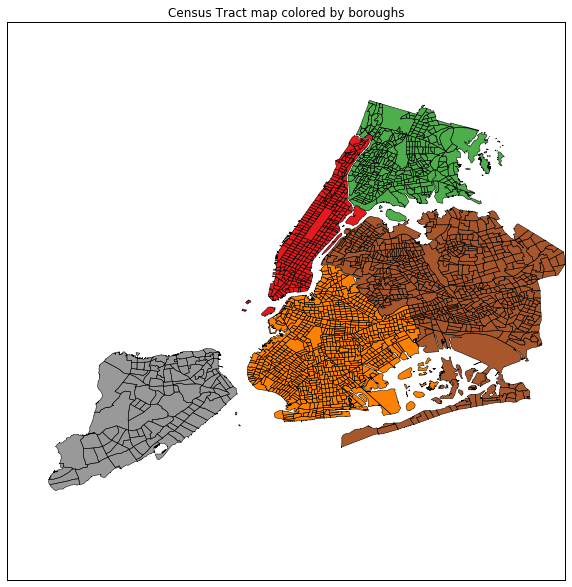

In [4]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column='BoroCode',alpha=1,linewidth=0.5,ax=ax)
plt.title("Census Tract map colored by boroughs")

### Map NYC Population density

#### Load Census Data for 2010  social explorer dot come


In [5]:
ct_data=DataFrame.from_csv('Data/ACS_CT2010.csv')
#set index to be the BoroCT2010 code
ct_data.index=ct_data.BoroCT2010.astype(str)
print (ct_data.index)

Index([u'5000900', u'5012500', u'5013301', u'5019700', u'5002002', u'5006400',
       u'5007400', u'5018701', u'1002202', u'1003200',
       ...
       u'1002800', u'1004400', u'4137700', u'4138502', u'1028700', u'1029700',
       u'3000100', u'3000301', u'1023300', u'1023700'],
      dtype='object', name=u'BoroCT2010', length=2166)


#### Add popuation density to CT shapefile

In [6]:
ct_shape_pop=ct_shape.join(ct_data[['SE_T002_002']]) #SE_T002_002 is population density in social explorer dataset

#### Vusualize the Population density for 2010

C:\Users\ferna\Anaconda2\lib\site-packages\geopandas\plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


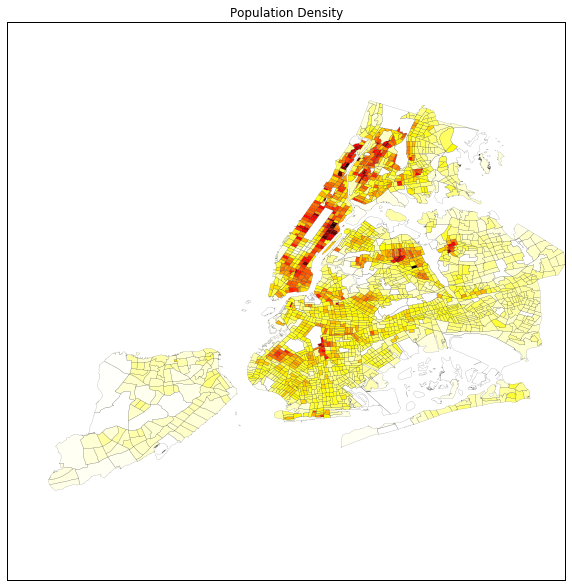

In [7]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_pop.plot(column='SE_T002_002',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Population Density")

## Explore CitiBike data

### Load CitiBike data

In [22]:
df_bike_monthly=DataFrame.from_csv('Data/CitiBike_monthly_byStation.csv')
df_bike_monthly.head(50)

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,0,0
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,0
2013-12-31,1299,1650,4081,1686,3046,1575,830,1890,2048,1009,...,0,0,0,0,0,0,0,0,0,0
2014-01-31,956,1337,3178,1251,1920,1130,477,1412,1082,681,...,0,0,0,0,0,0,0,0,0,0
2014-02-28,650,960,2920,676,1808,933,508,1045,963,530,...,0,0,0,0,0,0,0,0,0,0
2014-03-31,804,1559,5102,1441,2643,1477,849,2004,2105,880,...,0,0,0,0,0,0,0,0,0,0


In [105]:
##Winter months 10,11,12,01,02,03, summer months 04,05,06,07,08,09 NYC
wintermonths = ['11','12','01','02','03', '04']
summermonths = ['05','06','07','08','09', '10']

df_bike_monthly['season'] = 'Nan'
df_bike_monthly.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1534,1535,1536,1537,1538,1539,1540,1541,1542,season
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,Nan
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,Nan
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,Nan
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,0,Nan
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,Nan


In [106]:
for i in range(len(df_bike_monthly)):
    if ((str(df_bike_monthly.index[i])[5:7] == '10') | (str(df_bike_monthly.index[i])[5:7] == '05') | (str(df_bike_monthly.index[i])[5:7] == '06') | (str(df_bike_monthly.index[i])[5:7] == '07') | (str(df_bike_monthly.index[i])[5:7] == '08') | (str(df_bike_monthly.index[i])[5:7] == '09')):
        df_bike_monthly['season'][i] = 'summer'
        print str(df_bike_monthly.index[i])[5:7], 'summer' 
    else:
        df_bike_monthly['season'][i] = 'winter'
        print str(df_bike_monthly.index[i])[5:7] 

C:\Users\ferna\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


07 summer
08 summer
09 summer
10 summer


C:\Users\ferna\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


11
12
01
02
03
04
05 summer
06 summer
07 summer
08 summer
09 summer
10 summer
11
12
01
02
03
04
05 summer
06 summer
07 summer
08 summer
09 summer
10 summer
11
12
01
02
03
04
05 summer
06 summer


In [107]:
df_bike_monthly.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1534,1535,1536,1537,1538,1539,1540,1541,1542,season
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,summer
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,summer
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,summer
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,0,summer
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,winter


In [108]:
df_bike_monthly_winter = df_bike_monthly[df_bike_monthly.season == 'winter']
df_bike_monthly_summer = df_bike_monthly[df_bike_monthly.season == 'summer']
df_bike_monthly_winter = df_bike_monthly_winter.iloc[:,:-1]
df_bike_monthly_summer = df_bike_monthly_summer.iloc[:,:-1]

### Time Series Aanalysis

C:\Users\ferna\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


(-200, 16000)

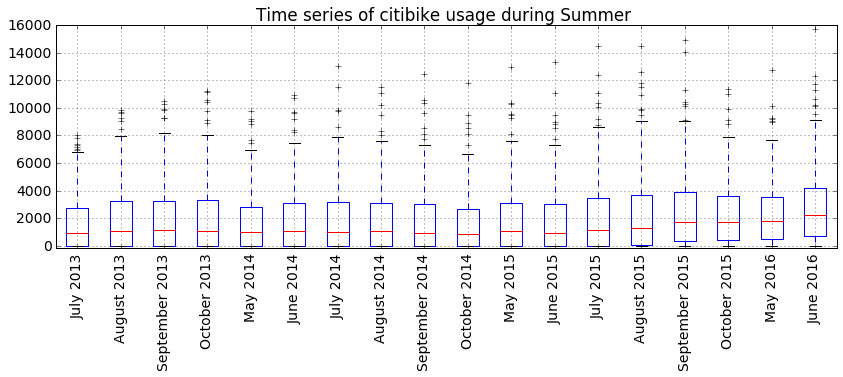

In [109]:
plt.rcParams['font.size']=14
f, ax = plt.subplots(figsize=(14,4))
#create a copy of the df for the viz purposes
df_bike_monthly_summer_=df_bike_monthly_summer.copy()
df_bike_monthly_summer_.index=df_bike_monthly_summer_.index.strftime("%B %Y")
df_bike_monthly_summer_.T.boxplot(figsize=(15,7),ax=ax,rot=90);
ax.set_title('Time series of citibike usage during Summer ')
ax.set_ylim([-200,16000])

C:\Users\ferna\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


(-200, 16000)

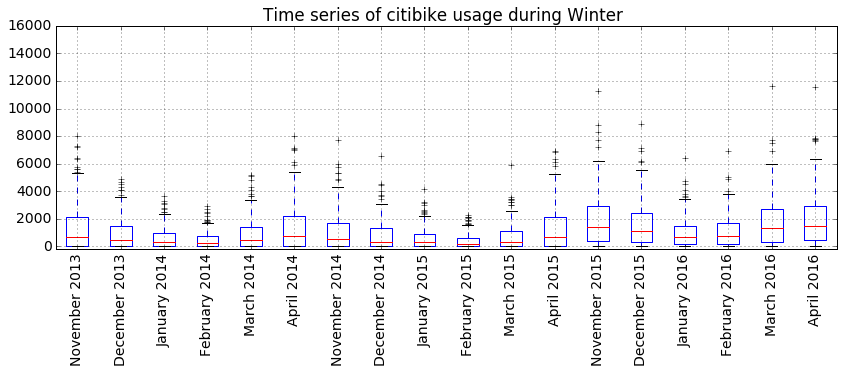

In [110]:
plt.rcParams['font.size']=14
f, ax = plt.subplots(figsize=(14,4))
#create a copy of the df for the viz purposes
df_bike_monthly_winter_=df_bike_monthly_winter.copy()
df_bike_monthly_winter_.index=df_bike_monthly_winter_.index.strftime("%B %Y")
df_bike_monthly_winter_.T.boxplot(figsize=(15,7),ax=ax,rot=90);
ax.set_title('Time series of citibike usage during Winter ')
ax.set_ylim([-200,16000])

#### Summer period Decomposition

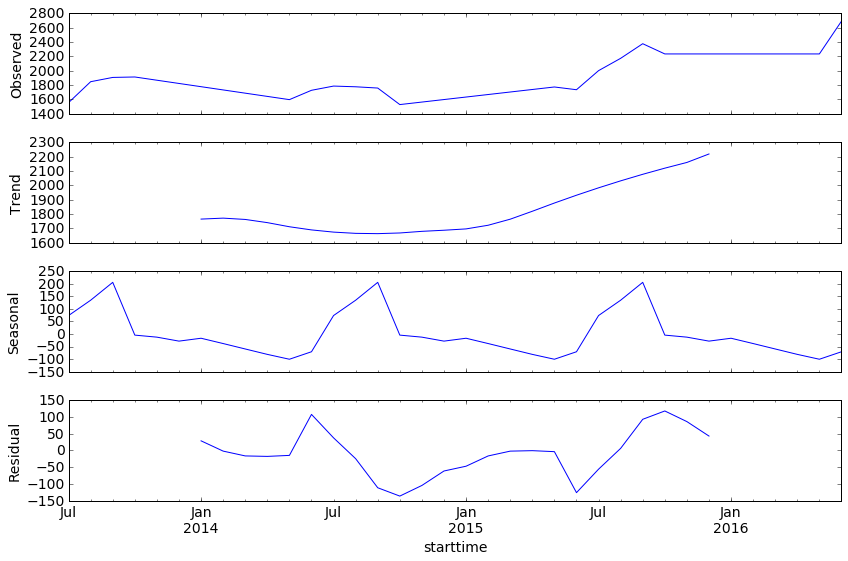

In [111]:
import statsmodels.api as sm

#Create a monthly time seriebbs of bike ride (Average of all citibike stations)
df_summer=df_bike_monthly_summer.mean(1).resample('M').mean()
df_summer.interpolate(inplace=True)

#Seasonal Decomposition using statsmodels api
res = sm.tsa.seasonal_decompose(df_summer.dropna())
plt.rcParams['figure.figsize']=(12,8)
resplot = res.plot()

#### Winter period Decomposition

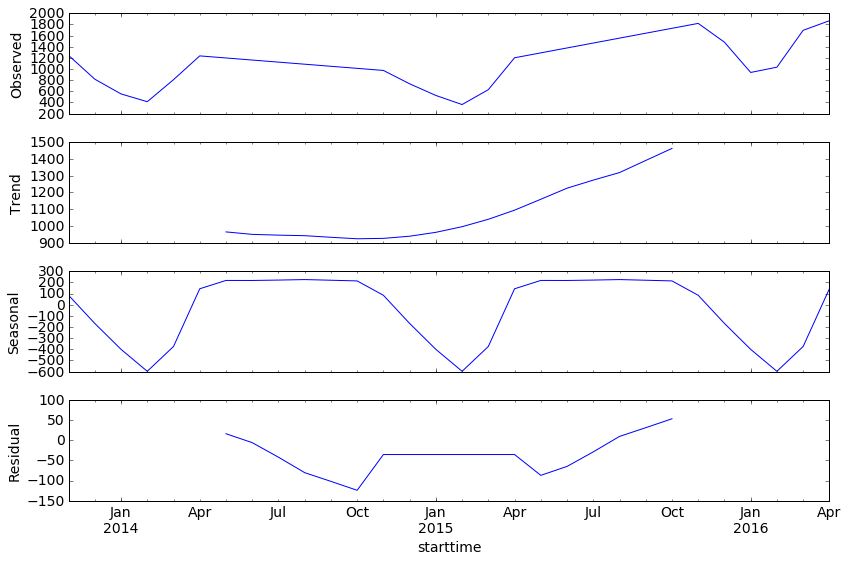

In [113]:
df_winter=df_bike_monthly_winter.mean(1).resample('M').mean()
df_winter.interpolate(inplace=True)

#Seasonal Decomposition using statsmodels api
res = sm.tsa.seasonal_decompose(df_winter.dropna())
plt.rcParams['figure.figsize']=(12,8)
resplot = res.plot()

## Map CitiBike Data to CT level

### Load CitiBike station location data

In [114]:
station_id=DataFrame.from_csv('Data/Station_id.csv')
#convert station_ids to string index
station_id.index=station_id.index.astype(str)
station_id.head()

,lat,lon
1000,40.753231,-73.970325
1001,40.749718,-74.002950
1002,40.730287,-73.990765
1003,40.718939,-73.992663
1004,40.734927,-73.992005


### Create CitiBike station Geometry (Point) from Corrdinates (Lat & Lon)

In [115]:
import shapely
# combine lat and lon to one column
station_id['lonlat']=zip(station_id.lon,station_id.lat)
# Create Point Geometry for based on lonlat column
station_id['geometry']=station_id[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
station_id.head()

,lat,lon,lonlat,geometry
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098)
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753)
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666)
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904)
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695)


### Intersect the two geometries

In [116]:
a=[]
# check for each citibike stations to see what CT they are belong to
for i in range(len(station_id)):
    a.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)].BoroCT2010.values[0])
    print '\r',"%",str((i+1)*100./len(station_id))[:4],
station_id['BoroCT2010']=a

% 100.


In [117]:
station_id.BoroCT2010.head()

1000    1009000
1001    1009900
1002    1005700
1003    1001800
1004    1006100
Name: BoroCT2010, dtype: object

### Add Monthly rides to the station GeoDataFrame with CT code

In [142]:
### Create average monthly rides column from monthly citibike data and add it to the station id which has the geometry
station_id['SummerMonthlyAve']=df_bike_monthly_summer.sum()
station_id['WinterMonthlyAve']=df_bike_monthly_winter.sum()

In [143]:
station_id.head()

,lat,lon,lonlat,geometry,BoroCT2010,MonthlyAve,SummerMonthlyAve,WinterMonthlyAve
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,45373,45373,23935
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,70620,70620,32204
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,177744,177744,95781
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,66116,66116,35833
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,123644,123644,60400


### Add the monthly average rides to the CT shapefile 

In [156]:
temp1=station_id[['SummerMonthlyAve']]
temp1['station_id']=station_id.index
temp1.index=station_id['BoroCT2010']
ct_shape_SummerMonthlyAve=ct_shape.join(temp1)
ct_shape_SummerMonthlyAve.fillna(0,inplace=True)

C:\Users\ferna\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


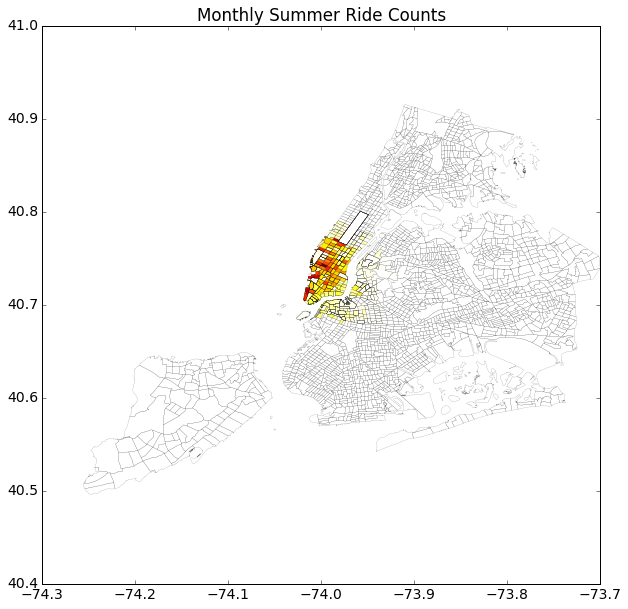

In [157]:
f, ax = plt.subplots(figsize=(10,10))
ct_shape_SummerMonthlyAve.plot(column='SummerMonthlyAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Monthly Summer Ride Counts")

In [158]:
temp2=station_id[['WinterMonthlyAve']]
temp2['station_id']=station_id.index
temp2.index=station_id['BoroCT2010']
ct_shape_WinterMonthlyAve=ct_shape.join(temp2)
ct_shape_WinterMonthlyAve.fillna(0,inplace=True)

C:\Users\ferna\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


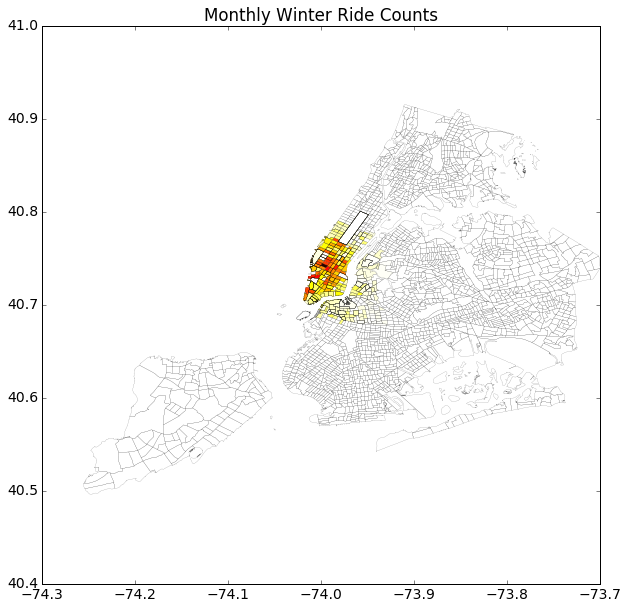

In [159]:
f, ax = plt.subplots(figsize=(10,10))
ct_shape_WinterMonthlyAve.plot(column='WinterMonthlyAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Monthly Winter Ride Counts")

### Removing the CTs that are out of zoom boundries

In [160]:
ct_shape_SummerMonthlyAve_Zoom=(ct_shape_SummerMonthlyAve[ct_shape_SummerMonthlyAve
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

In [161]:
print "Total number of CTs:", len(ct_shape)
print "Number of zoomed CTs:", len(temp1.SummerMonthlyAve)

Total number of CTs: 2166
Number of zoomed CTs: 543


In [165]:
ct_shape_WinterMonthlyAve_Zoom=(ct_shape_WinterMonthlyAve[ct_shape_WinterMonthlyAve
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

In [166]:
print "Total number of CTs:", len(ct_shape)
print "Number of zoomed CTs:", len(temp2.WinterMonthlyAve)

Total number of CTs: 2166
Number of zoomed CTs: 543


### Map the monthly rides 

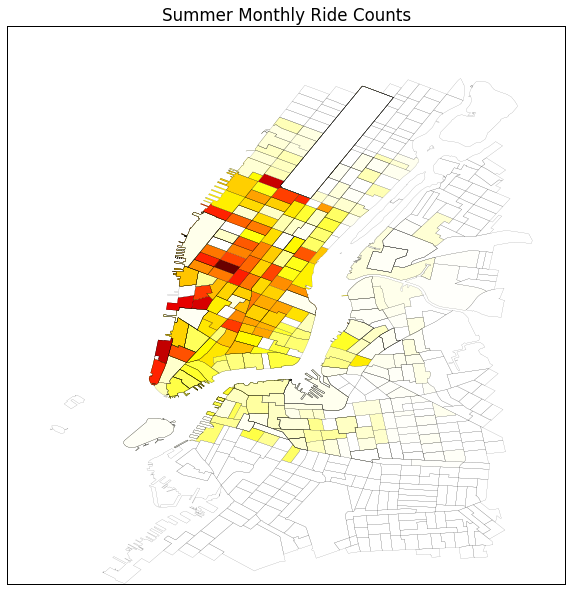

In [167]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_SummerMonthlyAve_Zoom.plot(column='SummerMonthlyAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Summer Monthly Ride Counts")

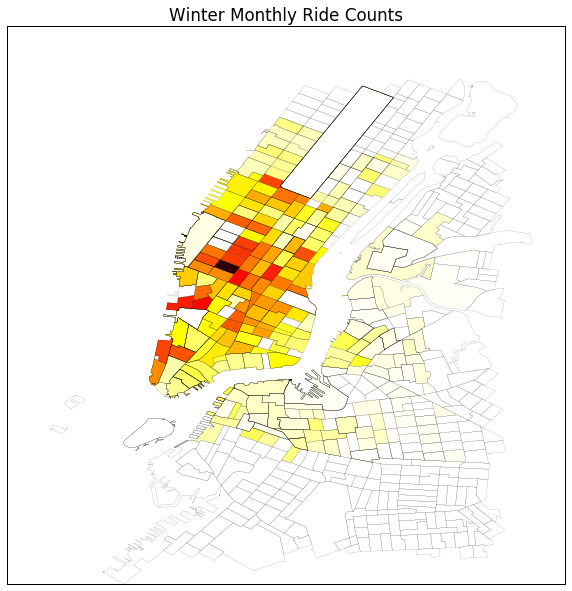

In [168]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_WinterMonthlyAve_Zoom.plot(column='WinterMonthlyAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Winter Monthly Ride Counts")

### Export Shapefile CTs in the CitiBike Zone

In [169]:
path='Output/ct_shape_SummerMonthlyAve_Zoom.shp'
ct_shape_SummerMonthlyAve_Zoom.to_file(path)

In [170]:
path='Output/ct_shape_WinterMonthlyAve_Zoom.shp'
ct_shape_WinterMonthlyAve_Zoom.to_file(path)

## Exploratory Geospatial Analysis

In [171]:
import pysal as ps

### Spatial Weights
Contiguity: Queen Weights

In [172]:
qW_CT=ps.queen_from_shapefile(path)

('Island id: ', [0])


#### Neighbors of index10

In [173]:
qW_CT[10]

{1: 1.0, 8: 1.0, 9: 1.0, 18: 1.0, 19: 1.0, 30: 1.0, 37: 1.0, 38: 1.0, 39: 1.0}

In [174]:
qW_CT.cardinalities[10]

9

#### Matrix of Weights

In [175]:
Wmatrix, ids = qW_CT.full()

In [176]:
Wmatrix

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

#### Change the matrix to be row-standardized

In [177]:
qW_CT.transform = 'r'

('WARNING: ', 0, ' is an island (no neighbors)')


### Spatial Lag  
Similarity of CT neibors can be meseard by means of spatial lag as follow:
$$BikeRideCountLag = \sum_j w_{i,j} BikeRideCount$$

#### Create Quantiles for maping

In [178]:
MonthlyRideSummer=ct_shape_SummerMonthlyAve_Zoom.SummerMonthlyAve
MonthlyRideLagSummer=ps.lag_spatial(qW_CT, MonthlyRideSummer)

In [179]:
MonthlyRideLagQ10Summer = ps.Quantiles(MonthlyRideLagSummer, k=10)
MonthlyRideLagQ10Summer

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               140
    0.000 < x[i] <=   144.857                21
  144.857 < x[i] <=  2456.500                78
 2456.500 < x[i] <=  5724.889                80
 5724.889 < x[i] <= 11566.075                79
11566.075 < x[i] <= 17837.800                80
17837.800 < x[i] <= 37784.389                79
37784.389 < x[i] <= 55150.786                80
55150.786 < x[i] <= 63650.794                79
63650.794 < x[i] <= 97593.429                80

In [181]:
MonthlyRideWinter=ct_shape_WinterMonthlyAve_Zoom.WinterMonthlyAve
MonthlyRideLagWinter=ps.lag_spatial(qW_CT, MonthlyRideWinter)

In [182]:
MonthlyRideLagQ10Winter = ps.Quantiles(MonthlyRideLagWinter, k=10)
MonthlyRideLagQ10Winter

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               159
    0.000 < x[i] <=    92.714                 2
   92.714 < x[i] <=  1624.250                78
 1624.250 < x[i] <=  4018.294                80
 4018.294 < x[i] <=  6274.828                79
 6274.828 < x[i] <=  9356.333                80
 9356.333 < x[i] <= 20433.494                79
20433.494 < x[i] <= 27914.276                80
27914.276 < x[i] <= 33315.668                79
33315.668 < x[i] <= 54389.929                80

#### Map the monthly rides lag

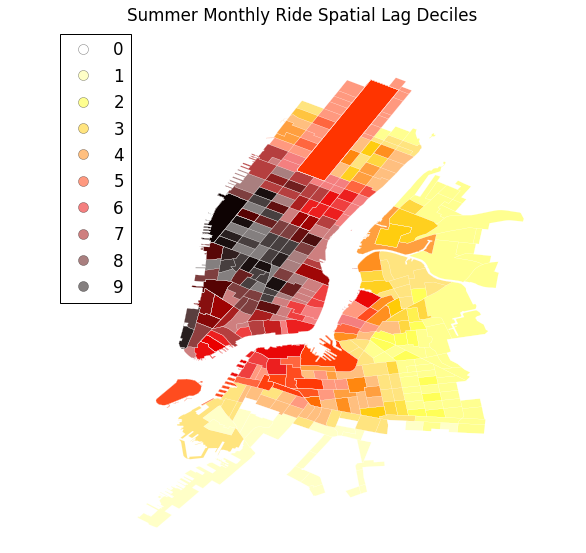

In [183]:
f, ax = plt.subplots(figsize=(9, 9))
ct_shape_SummerMonthlyAve_Zoom.assign(cl=MonthlyRideLagQ10Summer.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Summer Monthly Ride Spatial Lag Deciles")


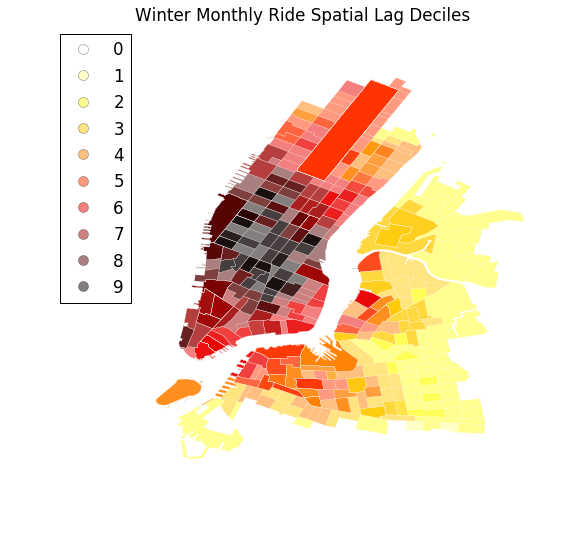

In [184]:
f, ax = plt.subplots(figsize=(9, 9))
ct_shape_WinterMonthlyAve_Zoom.assign(cl=MonthlyRideLagQ10Winter.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Winter Monthly Ride Spatial Lag Deciles")


## Global  Spatial Autocorrelation

In [185]:
b1,a1 = np.polyfit(MonthlyRideSummer, MonthlyRideLagSummer, 1)
b1,a1 

(0.64617661201524912, 8416.8106808882367)

In [186]:
b2,a2 = np.polyfit(MonthlyRideWinter, MonthlyRideLagWinter, 1)
b2,a2 

(0.6612592892020549, 4293.6780316496934)

### Moran Scatterplot

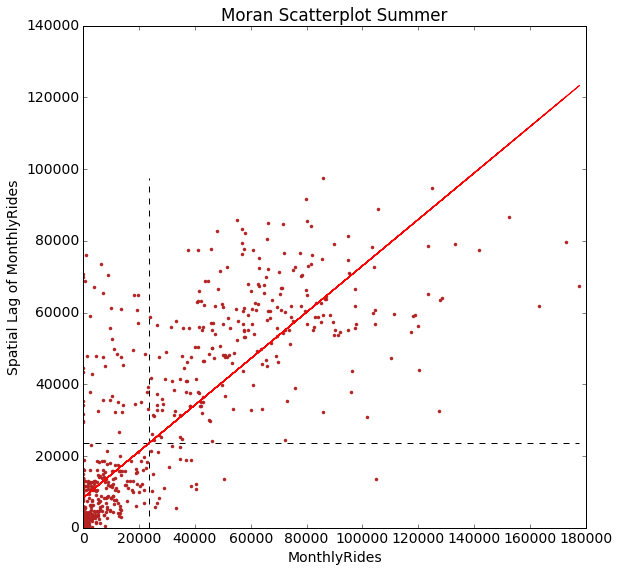

In [187]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(MonthlyRideSummer, MonthlyRideLagSummer, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRideSummer.mean(), MonthlyRideLagSummer.min(), MonthlyRideLagSummer.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLagSummer.mean(), MonthlyRideSummer.min(), MonthlyRideSummer.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRideSummer, a1 + b1*MonthlyRide, 'r')
plt.title('Moran Scatterplot Summer')
plt.ylabel('Spatial Lag of MonthlyRides')
plt.xlabel('MonthlyRides')

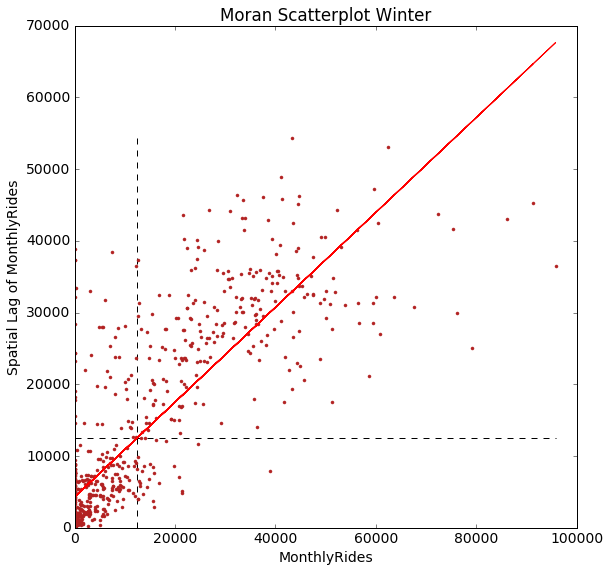

In [188]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(MonthlyRideWinter, MonthlyRideLagWinter, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRideWinter.mean(), MonthlyRideLagWinter.min(), MonthlyRideLagWinter.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLagWinter.mean(), MonthlyRideWinter.min(), MonthlyRideWinter.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRideWinter, a2 + b2*MonthlyRideWinter, 'r')
plt.title('Moran Scatterplot Winter')
plt.ylabel('Spatial Lag of MonthlyRides')
plt.xlabel('MonthlyRides')

### Moran's I

In [193]:
I_MonthlyRideSummer = ps.Moran(MonthlyRideSummer, qW_CT)

In [194]:
I_MonthlyRideSummer.I, I_MonthlyRideSummer.p_sim

(0.64633998396618797, 0.001)

In [195]:
I_MonthlyRideWinter = ps.Moran(MonthlyRideWinter, qW_CT)

In [196]:
I_MonthlyRideWinter.I, I_MonthlyRideWinter.p_sim

(0.66140507880103105, 0.001)

Thus, the $I$ statistic is $0.656$ for this data, and has a very small $p$ value. 

In [197]:
I_MonthlyRideSummer.sim[0:10]

array([-0.0311556 , -0.00917525, -0.0116785 , -0.02277667, -0.00842096,
        0.00030689, -0.01311552,  0.01006404,  0.01213389,  0.00067798])

In [198]:
I_MonthlyRideWinter.sim[0:10]

array([ 0.01801606, -0.01848522, -0.00789035,  0.00634983, -0.04319645,
        0.03871781,  0.00089038,  0.00434214, -0.00751024, -0.00840203])

### KDEplot of all of the simulated points
the vertical line shows the observed value

In [199]:
import seaborn as sns
plt.rcParams['figure.figsize']=(14,3)

(-0.7, 0.7)

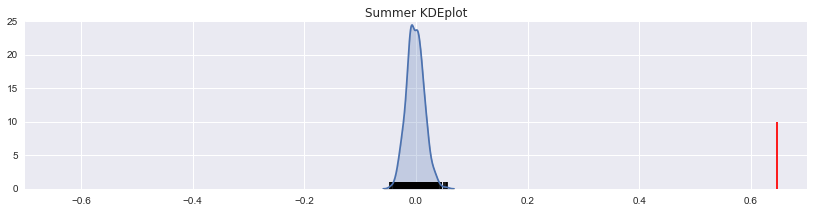

In [202]:
sns.kdeplot(I_MonthlyRideSummer.sim, shade=True)
plt.vlines(I_MonthlyRideSummer.sim, 0, 1)
plt.vlines(I_MonthlyRideSummer.I, 0, 10, 'r')
plt.title('Summer KDEplot')
plt.xlim([-.70, .70])

(-0.7, 0.7)

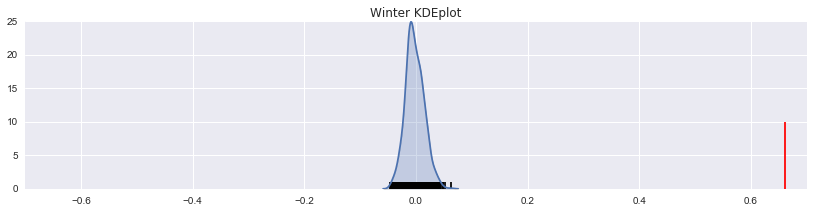

In [203]:
sns.kdeplot(I_MonthlyRideWinter.sim, shade=True)
plt.vlines(I_MonthlyRideWinter.sim, 0, 1)
plt.vlines(I_MonthlyRideWinter.I, 0, 10, 'r')
plt.title('Winter KDEplot')
plt.xlim([-.70, .70])

In the following figure the vertical line is showing if our $I$ statistic were close to our expected value

(-0.7, 0.7)

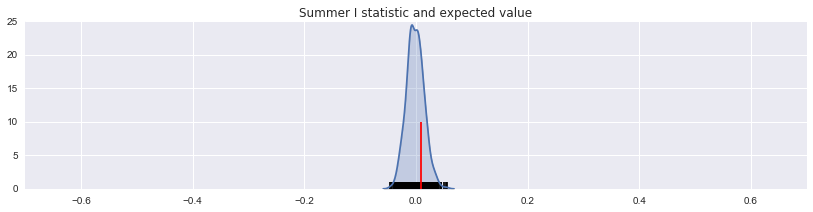

In [204]:
sns.kdeplot(I_MonthlyRideSummer.sim, shade=True)
plt.vlines(I_MonthlyRideSummer.sim, 0, 1)
plt.vlines(I_MonthlyRideSummer.EI+.01, 0, 10, 'r')
plt.title('Summer I statistic and expected value')
plt.xlim([-.70, .70])

(-0.7, 0.7)

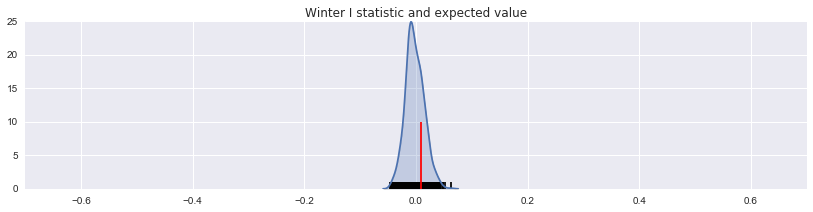

In [208]:
sns.kdeplot(I_MonthlyRideWinter.sim, shade=True)
plt.vlines(I_MonthlyRideWinter.sim, 0, 1)
plt.vlines(I_MonthlyRideWinter.EI+.01, 0, 10, 'r')
plt.title('Winter I statistic and expected value')
plt.xlim([-.70, .70])

## Local  Spatial Autocorrelation

In [209]:
LMo_MonthlyRideSummer = ps.Moran_Local(MonthlyRideSummer, qW_CT,permutations=999)

In [210]:
LMo_MonthlyRideSummer.Is[0:5], LMo_MonthlyRideSummer.p_sim[0:5]

(array([-0.        , -0.23543136,  0.00791709,  0.00253392,  0.01772575]),
 array([ 0.001,  0.169,  0.374,  0.363,  0.408]))

In [211]:
LMo_MonthlyRideWinter = ps.Moran_Local(MonthlyRideWinter, qW_CT,permutations=999)

In [212]:
LMo_MonthlyRideWinter.Is[0:5], LMo_MonthlyRideWinter.p_sim[0:5]

(array([ -0.00000000e+00,  -2.83046856e-01,  -6.06024526e-04,
          1.55249543e-04,  -3.66289401e-02]),
 array([ 0.001,  0.156,  0.49 ,  0.455,  0.476]))

### LISA (Local Indicators of Spatial Autocorrelation)

In [213]:
sigs1 = MonthlyRideSummer[LMo_MonthlyRideSummer.p_sim <= .001]
W_sigs1 = MonthlyRideLagSummer[LMo_MonthlyRideSummer.p_sim <= .001]
insigs1 = MonthlyRideSummer[LMo_MonthlyRideSummer.p_sim > .001]
W_insigs1 = MonthlyRideLagSummer[LMo_MonthlyRideSummer.p_sim > .001]

In [214]:
sigs2 = MonthlyRideWinter[LMo_MonthlyRideWinter.p_sim <= .001]
W_sigs2 = MonthlyRideLagWinter[LMo_MonthlyRideWinter.p_sim <= .001]
insigs2 = MonthlyRideWinter[LMo_MonthlyRideWinter.p_sim > .001]
W_insigs2 = MonthlyRideLagWinter[LMo_MonthlyRideWinter.p_sim > .001]

### Plot Signficant LISA

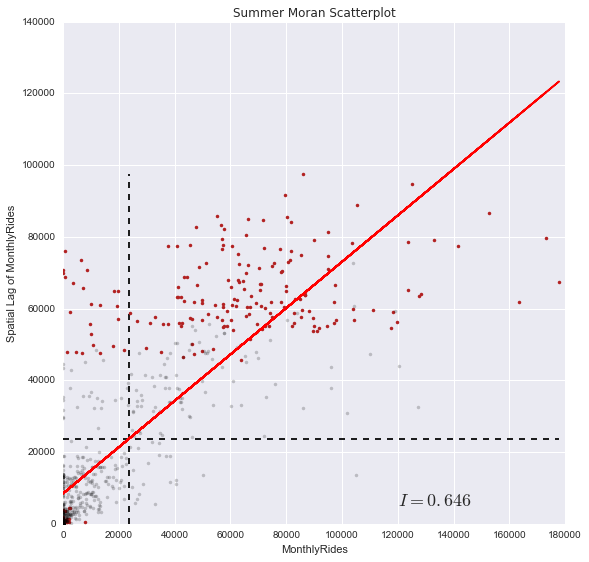

In [216]:
f, ax = plt.subplots(figsize=(9, 9))
plt.plot(sigs1, W_sigs1, '.', color='firebrick')
plt.plot(insigs1, W_insigs1, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % I_MonthlyRideSummer.I, x=120000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRideSummer.mean(), MonthlyRideLagSummer.min(), MonthlyRideLagSummer.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLagSummer.mean(), MonthlyRideSummer.min(), MonthlyRideSummer.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRideSummer, a1 + b1*MonthlyRideSummer, 'r')
plt.title('Summer Moran Scatterplot')
plt.ylabel('Spatial Lag of MonthlyRides')
plt.xlabel('MonthlyRides')

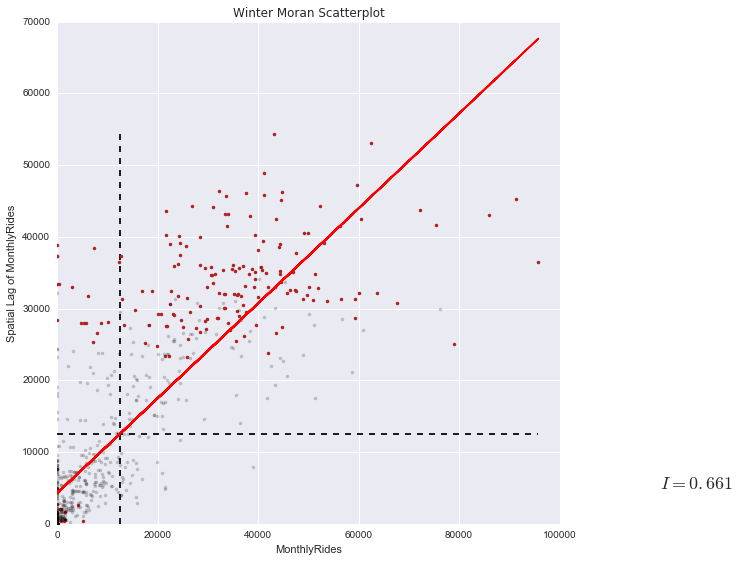

In [217]:
f, ax = plt.subplots(figsize=(9, 9))
plt.plot(sigs2, W_sigs2, '.', color='firebrick')
plt.plot(insigs2, W_insigs2, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % I_MonthlyRideWinter.I, x=120000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRideWinter.mean(), MonthlyRideLagWinter.min(), MonthlyRideLagWinter.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLagWinter.mean(), MonthlyRideWinter.min(), MonthlyRideWinter.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRideWinter, a2 + b2*MonthlyRideWinter, 'r')
plt.title('Winter Moran Scatterplot')
plt.ylabel('Spatial Lag of MonthlyRides')
plt.xlabel('MonthlyRides')

### Hot and Cold spots 

In [223]:
sig1 = LMo_MonthlyRideSummer.p_sim < 0.01
hotspotsSummer = LMo_MonthlyRideSummer.q==1 * sig1
coldspotsSummer = LMo_MonthlyRideSummer.q==3 * sig1
print "Summer Number of Hotspots:", hotspotsSummer.sum()
print "Summer Number of Coldspots:", coldspotsSummer.sum()

Summer Number of Hotspots: 188
Summer Number of Coldspots: 234


In [224]:
sig2 = LMo_MonthlyRideWinter.p_sim < 0.01
hotspotsWinter = LMo_MonthlyRideWinter.q==1 * sig2
coldspotsWinter = LMo_MonthlyRideWinter.q==3 * sig2
print "Winter Number of Hotspots:", hotspotsWinter.sum()
print "Winter Number of Coldspots:", coldspotsWinter.sum()

Winter Number of Hotspots: 197
Winter Number of Coldspots: 217


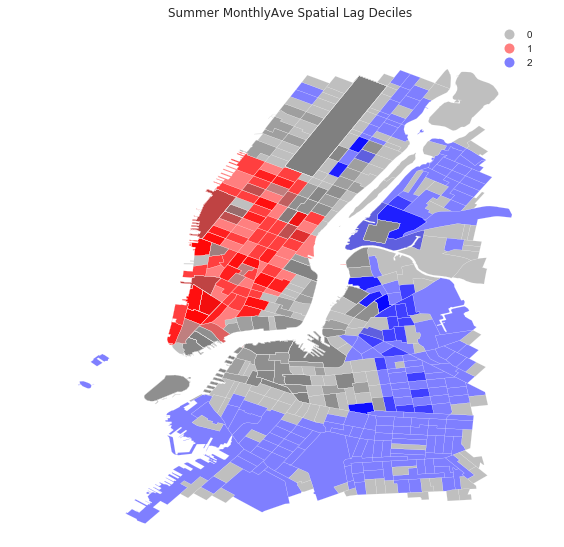

In [227]:
from matplotlib import colors

hcmap = colors.ListedColormap(['grey','red','blue'])
hotcoldSummer = hotspotsSummer*1 + coldspotsSummer*2

f, ax = plt.subplots(figsize=(9, 9))
ct_shape_SummerMonthlyAve_Zoom.assign(cl=hotcoldSummer).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Summer MonthlyAve Spatial Lag Deciles")

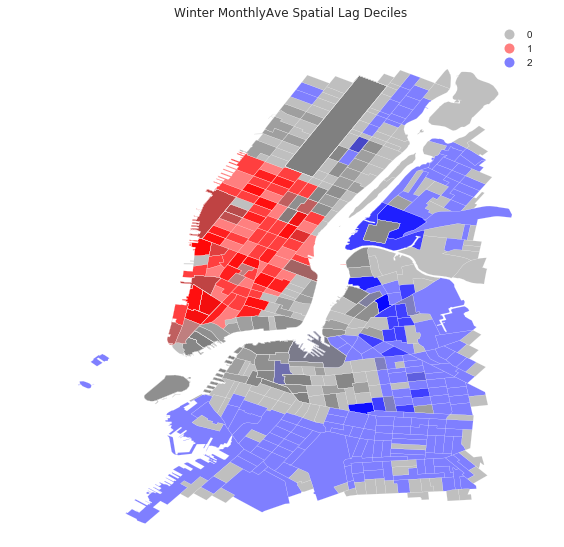

In [228]:
hotcoldWinter = hotspotsWinter*1 + coldspotsWinter*2

f, ax = plt.subplots(figsize=(9, 9))
ct_shape_WinterMonthlyAve_Zoom.assign(cl=hotcoldWinter).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Winter MonthlyAve Spatial Lag Deciles")